In [41]:
import os
import pandas as pd
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PDFPlumberLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import VectorStore
import google.generativeai as genai
import tempfile
from typing import List

# Initialize Gemini
def init_gemini():
    api_key = os.getenv("GOOGLE_API_KEY")
    genai.configure(api_key=api_key)

# Load and split PDF into chunks
def load_and_prepare_docs(pdf_path: str) -> VectorStore:
    init_gemini()

    # Load PDF using LangChain loader
    loader = PDFPlumberLoader(pdf_path)
    pages = loader.load()

    # Split into chunks
    splitter = CharacterTextSplitter(
        separator="\n",
        chunk_size=500,
        chunk_overlap=50,
        length_function=len,
    )
    documents = splitter.split_documents(pages)

    # Create embeddings
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

    # Create FAISS vectorstore
    vectorstore = FAISS.from_documents(documents, embeddings)
    return vectorstore

# Answer a question using Gemini + context from vectorstore
def answer_question(question: str, vectorstore: VectorStore) -> str:
    init_gemini()

    # Retrieve relevant context
    relevant_docs: List[Document] = vectorstore.similarity_search(question, k=5)
    context_text = "\n\n".join([doc.page_content for doc in relevant_docs])

    prompt = f"""Use the context below to answer the question. 
If the answer isn't in the context, check if the question is still relevant to the context. If it is, answer the question from your knowledge in brief.
If the question is irrelevant to the document and the answer is not in the context, say "I couldn't find that in the document."

Context:
{context_text}

Question: {question}
Answer:"""

    model = genai.GenerativeModel("gemini-2.0-flash")
    response = model.generate_content(prompt)

    return context_text

In [42]:
pdf_path = "/workspaces/RAG-based-Q-A-Chatbot/tests/GAEZ_Crop_profile_maize.pdf"
vectorstore = load_and_prepare_docs(pdf_path)

In [44]:
test_data = pd.read_csv("/workspaces/RAG-based-Q-A-Chatbot/tests/RAG Test - Sheet1.csv")

In [63]:
import time

batch_size = 2
wait_time = 10  # seconds

questions = test_data["Question"].tolist()

results = []

for start in range(0, len(questions), batch_size):
    batch = questions[start:start+batch_size]
    print(f"\n--- Batch {start//batch_size + 1} ---\n")
    
    for i, question in enumerate(batch, start=start):
        try:
            answer = answer_question(question, vectorstore)
            print(f"Q{i+1}: {question}")
            print(f"A{i+1}: {answer}\n")

            results.append({"Question": question, "Answer": answer})

        except Exception as e:
            print(f"Error on Q{i+1}: {e}")
            results.append({"Question": question, "Answer": f"Error: {e}"})
    
    # Save progress after each batch
    df = pd.DataFrame(results)
    df.to_csv("Retreival_results.csv", index=False)

    # Wait before next batch (avoid quota hit)
    if start + batch_size < len(questions):
        print(f"Waiting {wait_time} seconds before next batch...")
        time.sleep(wait_time)



--- Batch 1 ---

Q1: At what elevations can maize be found?
A1: THE GLOBAL AGRO-ECOLOGICAL ZONING version 4
Crop profile: Maize
GENERAL DESCRIPTION
A tall, coarse grass and grain crop with strong erect stalks and long narrow leaves,
maize can be found at elevations between sea level and 4,000 m and it can be grown
at latitudes from 48°N to 40°S.
Maize (temperate, subtropical and tropical lowland cultivars for grain and silage
maize with growth cycles of 90 to 180 days, tropical highland types of 120 up to 300

cropland. Results refer to the ensemble means of crop simulation outcomes using climate projections of five climate
models and for two RCPs, namely RCP 2.6 and RCP 8.5. In all continental regions, the extents suitable for maize increase
with climate change by the 2050s due to land becoming suitable with warming at higher latitudes and altitudes. Note
however, this trend stagnates or reverses with progressive climate change and in most regions suitable area in the

expansion of t

In [64]:
test_data

,Question,Ground Truth
0,At what elevations can maize be found?,Maize can be found at elevations between sea l...
1,What is the optimum temperature range for maiz...,The optimum temperature range for maize photos...
2,What happens to maize at temperatures between ...,Temperatures between 35°C and 40°C may cause h...
3,What is the minimum temperature for maize germ...,The minimum temperature for maize germination ...
4,What is the range of annual rainfall requireme...,Annual rainfall requirements for maize may var...
5,What was the global maize area for dry grain i...,The global maize area for dry grain in 2020 am...
6,Which continent accounted for the largest shar...,"In 2020, the Americas accounted for around 36%..."
7,What share of maize production is used as feed...,"At the global level, maize is primarily used a..."
8,What percentage of total maize production is u...,"At the global level, 13% of total maize produc..."
9,In which regions is maize an important human f...,Maize is an important human food crop in Sub-S...


In [65]:
retrieval_results = pd.read_csv("/workspaces/RAG-based-Q-A-Chatbot/Retreival_results.csv")

In [70]:
retrieval_results.rename(columns={'Answer':'Retrieved_Chunks'}, inplace=True)

In [72]:
retrieval_results["Relevant_Chunks"] = test_data["Ground Truth"]

In [73]:
retrieval_results

,Question,Retrieved_Chunks,Relevant_Chunks
0,At what elevations can maize be found?,THE GLOBAL AGRO-ECOLOGICAL ZONING version 4\nC...,Maize can be found at elevations between sea l...
1,What is the optimum temperature range for maiz...,days) is an annual crop belonging to the group...,The optimum temperature range for maize photos...
2,What happens to maize at temperatures between ...,days) is an annual crop belonging to the group...,Temperatures between 35°C and 40°C may cause h...
3,What is the minimum temperature for maize germ...,temperature for germination is 10°C and ideall...,The minimum temperature for maize germination ...
4,What is the range of annual rainfall requireme...,temperature for germination is 10°C and ideall...,Annual rainfall requirements for maize may var...
5,What was the global maize area for dry grain i...,"M ha (+ 89%), with an acceleration of area exp...",The global maize area for dry grain in 2020 am...
6,Which continent accounted for the largest shar...,FAOSTAT Statistics for 2020\nmaize area occurr...,"In 2020, the Americas accounted for around 36%..."
7,What share of maize production is used as feed...,"poor farmers (Shiferaw et al., 2011).\nFigure ...","At the global level, maize is primarily used a..."
8,What percentage of total maize production is u...,FAOSTAT Statistics for 2020\nmaize area occurr...,"At the global level, 13% of total maize produc..."
9,In which regions is maize an important human f...,"poor farmers (Shiferaw et al., 2011).\nFigure ...",Maize is an important human food crop in Sub-S...


In [82]:
# Wrap each string into a list
retrieval_results["Retrieved_Chunks"] = retrieval_results["Retrieved_Chunks"].apply(lambda x: [x])
retrieval_results["Relevant_Chunks"] = retrieval_results["Relevant_Chunks"].apply(lambda x: [x])

In [91]:
import numpy as np
from itertools import chain

coverage_list = []
reciprocal_ranks = []

for idx, row in retrieval_results.iterrows():
    # Flatten nested lists
    retrieved = list(chain.from_iterable(row["Retrieved_Chunks"]))
    relevant = list(chain.from_iterable(row["Relevant_Chunks"]))

    if len(relevant) == 0:
        coverage_list.append(0)
        reciprocal_ranks.append(0)
        continue

    # Coverage / Recall
    coverage = len(set(retrieved) & set(relevant)) / len(relevant)
    coverage_list.append(coverage)

    # Top-k / MRR
    rr = 0
    for rank, chunk in enumerate(retrieved, start=1):
        if chunk in relevant:
            rr = 1 / rank
            break
    reciprocal_ranks.append(rr)

# Add metrics to DataFrame
retrieval_results["Coverage"] = coverage_list
retrieval_results["Reciprocal_Rank"] = reciprocal_ranks

# Summary
mean_coverage = np.mean(coverage_list)
mean_mrr = np.mean(reciprocal_ranks)

print("Mean Coverage / Recall:", mean_coverage)
print("Mean Reciprocal Rank (MRR):", mean_mrr)


Mean Coverage / Recall: 0.28992404447964776
Mean Reciprocal Rank (MRR): 0.8113333333333332


In [92]:
retrieval_results

,Question,Retrieved_Chunks,Relevant_Chunks,Coverage,Reciprocal_Rank
0,At what elevations can maize be found?,[THE GLOBAL AGRO-ECOLOGICAL ZONING version 4\n...,[Maize can be found at elevations between sea ...,0.365079,0.250000
1,What is the optimum temperature range for maiz...,[days) is an annual crop belonging to the grou...,[The optimum temperature range for maize photo...,0.296703,1.000000
2,What happens to maize at temperatures between ...,[days) is an annual crop belonging to the grou...,[Temperatures between 35°C and 40°C may cause ...,0.236220,1.000000
3,What is the minimum temperature for maize germ...,[temperature for germination is 10°C and ideal...,[The minimum temperature for maize germination...,0.363636,1.000000
4,What is the range of annual rainfall requireme...,[temperature for germination is 10°C and ideal...,[Annual rainfall requirements for maize may va...,0.238938,1.000000
5,What was the global maize area for dry grain i...,"[M ha (+ 89%), with an acceleration of area ex...",[The global maize area for dry grain in 2020 a...,0.311688,0.500000
6,Which continent accounted for the largest shar...,[FAOSTAT Statistics for 2020\nmaize area occur...,"[In 2020, the Americas accounted for around 36...",0.366197,0.500000
7,What share of maize production is used as feed...,"[poor farmers (Shiferaw et al., 2011).\nFigure...","[At the global level, maize is primarily used ...",0.301075,1.000000
8,What percentage of total maize production is u...,[FAOSTAT Statistics for 2020\nmaize area occur...,"[At the global level, 13% of total maize produ...",0.397059,0.500000
9,In which regions is maize an important human f...,"[poor farmers (Shiferaw et al., 2011).\nFigure...",[Maize is an important human food crop in Sub-...,0.250000,1.000000


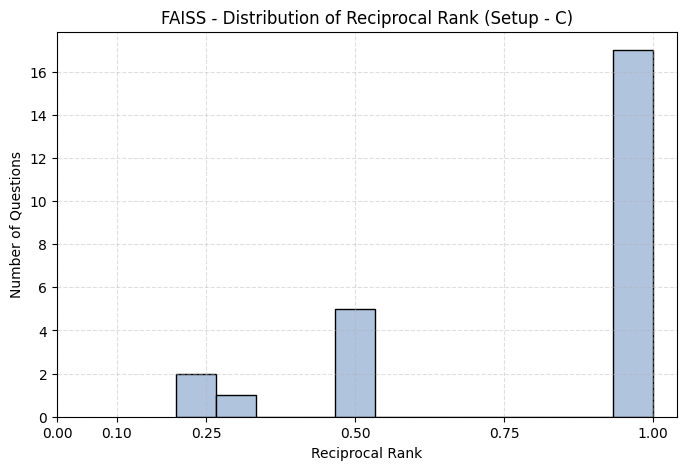

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(retrieval_results['Reciprocal_Rank'], bins=12, edgecolor='black', color='lightsteelblue')
plt.title('FAISS - Distribution of Reciprocal Rank (Setup - C)')
plt.xlabel('Reciprocal Rank')
plt.ylabel('Number of Questions')
plt.xticks([0, 0.1, 0.25, 0.5, 0.75, 1])
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()